In [1]:
import random
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from albumentations import Compose

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from visualizationUtils import plot_confusion_matrix
from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from lossesUtils import categorical_focal_loss
from bandUtils import Band 
from labelsUtils import (
    Label,
    LabelCategory,
    category_from_label,
    categories_from_label_set
)

from rasterUtils import make_dataset_from_raster_files
from regionUtils import (
    vietnam_labels_coordinates,
    sumatra_south_labels_coordinates,
    sumatra_center_labels_coordinates,
    sulawesi_labels_coordinates,
    para_north_labels_coordinates,
    para_center_labels_coordinates,
    ocotopeque_labels_coordinates,
    ghana_labels_coordinates,
    borneo_labels_coordinates
)
from convNetUtils import (
    images_from_dataset,
    labels_from_dataset,
    cross_validation,
    AUGMENTATIONS,
    ImageMultiOutputSequence,
    train_model,
    evaluate_multi_output_model
)

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
DATA_ROOT_PATH = '../data/'
MODEL_ROOT_PATH = '../models/'
NB_PIXEL_AROUND = 4
BANDS = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [3]:
# create a dataset per region
datasets = []

labels_coordinates_list = [
    sumatra_south_labels_coordinates(),
    sumatra_center_labels_coordinates(),
    para_north_labels_coordinates(),
    para_center_labels_coordinates(),
    # borneo_labels_coordinates(),
    sulawesi_labels_coordinates(),
    ghana_labels_coordinates(),
    ocotopeque_labels_coordinates()
]

datasets_name = [
    'Sumatra_south_2018_whole_year_collection2',
    'Sumatra_center_2018_whole_year_collection2',
    'Para_north_2018_whole_year_collection2',
    'Para_center_2018_whole_year_collection2',
    # 'Borneo_2018_whole_year_collection2',
    'Sulawesi_2018_whole_year_collection2',
    'Ghana_2019_whole_year_collection2',
    'Ocotopeque_2018_whole_year_collection2'
]


for i, dataset_name in enumerate(datasets_name):
    labels_coordinates = labels_coordinates_list[i]
    labels = [Label(label) for label in labels_coordinates if len(labels_coordinates[label]) > 5]
    categories = pd.unique([category_from_label(label) for label in labels])
        
    dataset_args = dict(
        labels = labels,
        raster_paths = [DATA_ROOT_PATH + dataset_name + '/merged.tif'],
        labels_coordinates_list = [labels_coordinates],
        nb_pixel_around = NB_PIXEL_AROUND
    )

    dataset = make_dataset_from_raster_files(**dataset_args)
    datasets.append((labels, len(categories), dataset))

In [4]:
size_min_datasets = min([len(dataset[2]) for dataset in datasets])
print(size_min_datasets)

2155


In [5]:
def task_from_dataset(dataset, labels, labels_names, nb_categories, nb_images=None):
    # Shuffle images order in dataset
    np.random.shuffle(dataset)
    
    if nb_images is not None:
        # Specify a number of images to sample
        dataset = random.choices(dataset, k=nb_images)

    labels_train = labels_from_dataset(dataset, labels_names)
    categories_train = categories_from_label_set(labels, labels_train)
    
    X_train = images_from_dataset(dataset, BANDS)
    y_train = [labels_train, categories_train]
    Y_train = [
        to_categorical(labels_train, num_classes=len(labels_names)), 
        to_categorical(categories_train, num_classes=nb_categories), 
    ]
    
    # Format true label sets for multi output
    Y_train = {
        output_name: Y_train[i] for i, output_name in enumerate(['label', 'category'])
    }
        
    return X_train, Y_train, len(labels_train) / 32


def iteration_tasks(datasets, nb_images=None):
    datasets_order = np.arange(len(datasets))
        
    # Shuffle datasets order
    np.random.shuffle(datasets_order)

    # Loop through every datasets in an iterastion
    for dataset_iter, dataset_idx in enumerate(datasets_order):
        labels, nb_categories, dataset = datasets[dataset_idx]
        labels_names = [label.name for label in labels]
        
        print(f"dataset index: {dataset_idx}, dataset iteration: {dataset_iter + 1}/{len(datasets)}, size: {len(dataset)}")
        
        X_train, Y_train, steps_per_epoch = task_from_dataset(dataset, labels, labels_names, nb_categories, nb_images)
                
        yield X_train, Y_train, steps_per_epoch, dataset_idx, len(labels_names), nb_categories

In [6]:
image_width = 9
image_height = 9
image_depth = len(BANDS)

# define model
inputs = Input(shape=(image_width, image_height, image_depth))
layers = Rescaling(1./2**16)(inputs)
layers = BatchNormalization()(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(layers)
layers = MaxPooling2D(pool_size=(3, 3))(layers)
layers = SpatialDropout2D(0.25)(layers)
layers = GlobalAveragePooling2D()(layers)
layers = Dense(128, activation='relu')(layers)
layers = Dropout(0.25, name="last_input_layer")(layers)

label_output = Dense(len(labels), activation='softmax', name="label")(layers)
category_output = Dense(len(LabelCategory), activation='softmax', name="category")(layers)

model = Model(inputs=inputs, outputs=[label_output, category_output])

## v1

In [7]:
# define hyperparameters
meta_step_size = 0.1
nb_iterations = 100
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])
                
        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")
        print(datasets_losses)

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/100
-----------------
dataset index: 3, dataset iteration: 1/8, size: 20687
- loss: 0.05874073877930641
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.46985748410224915
dataset index: 2, dataset iteration: 3/8, size: 2234
- loss: 0.14396362006664276
dataset index: 0, dataset iteration: 4/8, size: 11477
- loss: 0.07297229021787643
dataset index: 4, dataset iteration: 5/8, size: 89
- loss: 0.465379536151886
dataset index: 5, dataset iteration: 6/8, size: 3168
- loss: 0.32658612728118896
dataset index: 6, dataset iteration: 7/8, size: 7356
- loss: 0.35134708881378174
dataset index: 7, dataset iteration: 8/8, size: 59317
- loss: 0.06430808454751968
iteration: 2/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.06120006740093231
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.04855780676007271
dataset index: 5, dataset iteration: 3/8, size: 3168
- loss: 0.27057743072509766
dataset index: 4, dataset iteration: 4

- loss: 0.2082163393497467
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.022002479061484337
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.2222290188074112
dataset index: 5, dataset iteration: 4/8, size: 3168
- loss: 0.06961492449045181
dataset index: 7, dataset iteration: 5/8, size: 59317
- loss: 0.03367201238870621
dataset index: 0, dataset iteration: 6/8, size: 11477
- loss: 0.02999242953956127
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.08175142854452133
dataset index: 2, dataset iteration: 8/8, size: 2234
- loss: 0.00706707127392292
iteration: 14/100
-----------------
dataset index: 2, dataset iteration: 1/8, size: 2234
- loss: 0.0142222223803401
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.07136567682027817
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.031228486448526382
dataset index: 4, dataset iteration: 4/8, size: 89
- loss: 0.14225828647613525
dataset index: 3, dataset iteration: 5/8, size

- loss: 0.016033008694648743
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.05186954140663147
dataset index: 7, dataset iteration: 3/8, size: 59317
- loss: 0.026420269161462784
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0011027901200577617
dataset index: 4, dataset iteration: 5/8, size: 89
- loss: 0.12335013598203659
dataset index: 6, dataset iteration: 6/8, size: 7356
- loss: 0.1691891849040985
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.07116086035966873
dataset index: 0, dataset iteration: 8/8, size: 11477
- loss: 0.02018759772181511
iteration: 26/100
-----------------
dataset index: 2, dataset iteration: 1/8, size: 2234
- loss: 0.0023105896543711424
dataset index: 7, dataset iteration: 2/8, size: 59317
- loss: 0.02791651338338852
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.06250021606683731
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.021997282281517982
dataset index: 0, dataset iteration: 

- loss: 0.12894323468208313
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.015890592709183693
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.053174108266830444
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.012095370329916477
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.004262649919837713
dataset index: 6, dataset iteration: 6/8, size: 7356
- loss: 0.1337817758321762
dataset index: 7, dataset iteration: 7/8, size: 59317
- loss: 0.02238648012280464
dataset index: 5, dataset iteration: 8/8, size: 3168
- loss: 0.043892018496990204
iteration: 38/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.022438732907176018
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.04514046013355255
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.14121542870998383
dataset index: 3, dataset iteration: 4/8, size: 20687
- loss: 0.01293379906564951
dataset index: 2, dataset iteration

- loss: 0.01028909906744957
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.04063040763139725
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.11893081665039062
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.002111084759235382
dataset index: 7, dataset iteration: 5/8, size: 59317
- loss: 0.017898518592119217
dataset index: 1, dataset iteration: 6/8, size: 2155
- loss: 0.04891146346926689
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.11106859892606735
dataset index: 0, dataset iteration: 8/8, size: 11477
- loss: 0.013723799958825111
iteration: 50/100
-----------------
dataset index: 6, dataset iteration: 1/8, size: 7356
- loss: 0.12276331335306168
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.016380053013563156
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.04225985333323479
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.01914667896926403
dataset index: 3, dataset iteration: 5/

- loss: 0.018794236704707146
dataset index: 0, dataset iteration: 2/8, size: 11477
- loss: 0.013808677904307842
dataset index: 6, dataset iteration: 3/8, size: 7356
- loss: 0.11425059288740158
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0008717922610230744
dataset index: 5, dataset iteration: 5/8, size: 3168
- loss: 0.03600792586803436
dataset index: 3, dataset iteration: 6/8, size: 20687
- loss: 0.010811951011419296
dataset index: 1, dataset iteration: 7/8, size: 2155
- loss: 0.0389619916677475
dataset index: 4, dataset iteration: 8/8, size: 89
- loss: 0.12471221387386322
iteration: 62/100
-----------------
dataset index: 6, dataset iteration: 1/8, size: 7356
- loss: 0.10856065899133682
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.008869224227964878
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.017112741246819496
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.020448394119739532
dataset index: 2, dataset iteration

- loss: 0.03254096955060959
dataset index: 3, dataset iteration: 2/8, size: 20687
- loss: 0.013668871484696865
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.01184204313904047
dataset index: 7, dataset iteration: 4/8, size: 59317
- loss: 0.0167051050812006
dataset index: 6, dataset iteration: 5/8, size: 7356
- loss: 0.11214657872915268
dataset index: 2, dataset iteration: 6/8, size: 2234
- loss: 0.0017862959066405892
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.1067841425538063
dataset index: 1, dataset iteration: 8/8, size: 2155
- loss: 0.03540033847093582
iteration: 74/100
-----------------
dataset index: 7, dataset iteration: 1/8, size: 59317
- loss: 0.01889627054333687
dataset index: 4, dataset iteration: 2/8, size: 89
- loss: 0.10121221095323563
dataset index: 0, dataset iteration: 3/8, size: 11477
- loss: 0.012824027799069881
dataset index: 1, dataset iteration: 4/8, size: 2155
- loss: 0.04058394581079483
dataset index: 3, dataset iteration: 5/8, 

- loss: 0.008902141824364662
dataset index: 7, dataset iteration: 2/8, size: 59317
- loss: 0.01761518605053425
dataset index: 1, dataset iteration: 3/8, size: 2155
- loss: 0.04433947801589966
dataset index: 0, dataset iteration: 4/8, size: 11477
- loss: 0.012736620381474495
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.0007028162362985313
dataset index: 5, dataset iteration: 6/8, size: 3168
- loss: 0.02909163571894169
dataset index: 4, dataset iteration: 7/8, size: 89
- loss: 0.10435602813959122
dataset index: 6, dataset iteration: 8/8, size: 7356
- loss: 0.10982891172170639
iteration: 86/100
-----------------
dataset index: 3, dataset iteration: 1/8, size: 20687
- loss: 0.012202258221805096
dataset index: 5, dataset iteration: 2/8, size: 3168
- loss: 0.027286062017083168
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.09406624734401703
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0006127496599219739
dataset index: 0, dataset iteration: 5

- loss: 0.00886926706880331
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.04531380906701088
dataset index: 5, dataset iteration: 3/8, size: 3168
- loss: 0.02915113791823387
dataset index: 6, dataset iteration: 4/8, size: 7356
- loss: 0.10564421117305756
dataset index: 2, dataset iteration: 5/8, size: 2234
- loss: 0.0016468653921037912
dataset index: 7, dataset iteration: 6/8, size: 59317
- loss: 0.017096631228923798
dataset index: 0, dataset iteration: 7/8, size: 11477
- loss: 0.014657813124358654
dataset index: 4, dataset iteration: 8/8, size: 89
- loss: 0.11893685907125473
iteration: 98/100
-----------------
dataset index: 5, dataset iteration: 1/8, size: 3168
- loss: 0.0322287417948246
dataset index: 1, dataset iteration: 2/8, size: 2155
- loss: 0.03626882657408714
dataset index: 4, dataset iteration: 3/8, size: 89
- loss: 0.09438557922840118
dataset index: 2, dataset iteration: 4/8, size: 2234
- loss: 0.0010346490889787674
dataset index: 3, dataset iteration: 5/8, 

0.014803510159254074
0.037254635244607925
0.0010234233923256397
0.007154997903853655
0.12222884595394135
0.03301871567964554
0.10456104576587677
0.016448354348540306


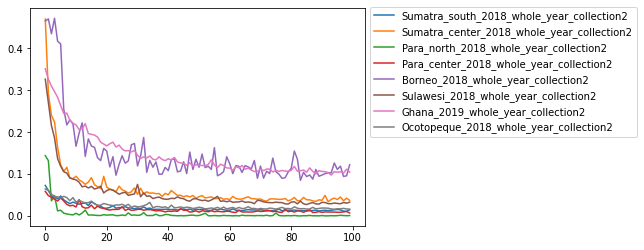

In [8]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [9]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_input_layer').output)

# save model
# model.save(MODEL_ROOT_PATH + 'multi_output_pretrained_with_reptile.hdf5')

## v2 (without borneo, diff hyperparameters)

In [12]:
# define hyperparameters
meta_step_size = 0.3
nb_iterations = 70
nb_inner_iters = 5
minibatches_size = 32

tasks_output_weights = [None for _ in np.arange(len(datasets))]
datasets_losses = [[] for _ in np.arange(len(datasets))]

for iteration in range(nb_iterations):
    print(f"iteration: {iteration + 1}/{nb_iterations}\n-----------------")
    
    for X_train, Y_train, steps_per_epoch, dataset_idx, nb_labels, nb_categories in iteration_tasks(datasets):
        # Create model with an new output layer for this task
        label_output = Dense(nb_labels, activation='softmax', name="label")(model.get_layer('last_input_layer').output)
        category_output = Dense(nb_categories, activation='softmax', name="category")(model.get_layer('last_input_layer').output)
        
        model = Model(inputs=inputs, outputs=[label_output, category_output])

        model.compile(optimizer='adam', loss={
            'label': categorical_focal_loss([[.25] * nb_labels]),
            'category': categorical_focal_loss([[.25] * nb_categories])
        })
        
        # If task as already been trained on, set back the previous weights of the output layer 
        if tasks_output_weights[dataset_idx] is not None :
            model.layers[-1].set_weights(tasks_output_weights[dataset_idx])        

        # Save old weights
        old_weights = model.get_weights()
        
        # Train
        model.fit(
            x=X_train,
            y=Y_train,
            epochs=nb_inner_iters,
            steps_per_epoch=steps_per_epoch,
            verbose=0
        )
        
        # Evaluate model on training data
        score = model.evaluate(X_train, Y_train, verbose=0)
        
        # Get new weights
        new_weights = model.get_weights()
        
        # Store dataset current loss and accuracies
        datasets_losses[dataset_idx].append(float(score[0]))
        
        print(f"- loss: {score[0]}")

        # Update weights
        for weight in range(len(new_weights)):
            current_meta_step_size = (1 - iteration / nb_iterations) * meta_step_size
            
            new_weights[weight] = old_weights[weight] + (
                (new_weights[weight] - old_weights[weight]) * current_meta_step_size
            )

        # After the meta-learning step, reload the newly-trained weights into the model.
        model.set_weights(new_weights)

        # Save task's output layer weights
        tasks_output_weights[dataset_idx] = model.layers[-1].get_weights()

iteration: 1/70
-----------------
dataset index: 5, dataset iteration: 1/7, size: 7356
- loss: 0.16129587590694427
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.014116722159087658
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.019060974940657616
dataset index: 1, dataset iteration: 4/7, size: 2155
- loss: 0.08580099791288376
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.024793194606900215
dataset index: 4, dataset iteration: 6/7, size: 3168
- loss: 0.07727942615747452
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.008143696933984756
iteration: 2/70
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.020028239116072655
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.08298172056674957
dataset index: 2, dataset iteration: 3/7, size: 2234
- loss: 0.0022906139492988586
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 0.16457001864910126
dataset index: 0, dataset iter

- loss: 0.015536928549408913
dataset index: 3, dataset iteration: 5/7, size: 20687
- loss: 0.010939880274236202
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.0014067406300455332
dataset index: 5, dataset iteration: 7/7, size: 7356
- loss: 0.13084252178668976
iteration: 15/70
-----------------
dataset index: 0, dataset iteration: 1/7, size: 11477
- loss: 0.012892061844468117
dataset index: 1, dataset iteration: 2/7, size: 2155
- loss: 0.05482836440205574
dataset index: 3, dataset iteration: 3/7, size: 20687
- loss: 0.009777184575796127
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 0.1165718138217926
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.04305393621325493
dataset index: 6, dataset iteration: 6/7, size: 59317
- loss: 0.01561631727963686
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.001504238578490913
iteration: 16/70
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0009711604216136038

- loss: 0.015157162211835384
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.0008299540495499969
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.040296465158462524
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.03825775161385536
dataset index: 0, dataset iteration: 5/7, size: 11477
- loss: 0.010820547118782997
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.0987669825553894
dataset index: 3, dataset iteration: 7/7, size: 20687
- loss: 0.00926009751856327
iteration: 29/70
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.000903735461179167
dataset index: 5, dataset iteration: 2/7, size: 7356
- loss: 0.09149156510829926
dataset index: 3, dataset iteration: 3/7, size: 20687
- loss: 0.008182630874216557
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.011342284269630909
dataset index: 6, dataset iteration: 5/7, size: 59317
- loss: 0.012754112482070923
dataset index: 4, dataset iterati

- loss: 0.03875456377863884
dataset index: 0, dataset iteration: 6/7, size: 11477
- loss: 0.011903888545930386
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.01988932304084301
iteration: 42/70
-----------------
dataset index: 6, dataset iteration: 1/7, size: 59317
- loss: 0.011829658411443233
dataset index: 2, dataset iteration: 2/7, size: 2234
- loss: 0.0007391965482383966
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.028560834005475044
dataset index: 5, dataset iteration: 4/7, size: 7356
- loss: 0.08567803353071213
dataset index: 1, dataset iteration: 5/7, size: 2155
- loss: 0.031746864318847656
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.00999330636113882
dataset index: 0, dataset iteration: 7/7, size: 11477
- loss: 0.01345476321876049
iteration: 43/70
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.0009577372693456709
dataset index: 4, dataset iteration: 2/7, size: 3168
- loss: 0.0267738625407218

- loss: 0.08076869696378708
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.011177940294146538
dataset index: 1, dataset iteration: 3/7, size: 2155
- loss: 0.0345795638859272
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.011537346057593822
dataset index: 4, dataset iteration: 5/7, size: 3168
- loss: 0.03573192283511162
dataset index: 3, dataset iteration: 6/7, size: 20687
- loss: 0.009288078173995018
dataset index: 2, dataset iteration: 7/7, size: 2234
- loss: 0.0003972554113715887
iteration: 56/70
-----------------
dataset index: 3, dataset iteration: 1/7, size: 20687
- loss: 0.007049723528325558
dataset index: 6, dataset iteration: 2/7, size: 59317
- loss: 0.010493694804608822
dataset index: 4, dataset iteration: 3/7, size: 3168
- loss: 0.0269114151597023
dataset index: 0, dataset iteration: 4/7, size: 11477
- loss: 0.008653073571622372
dataset index: 2, dataset iteration: 5/7, size: 2234
- loss: 0.0006483471370302141
dataset index: 5, dataset iterat

- loss: 0.00038057303754612803
dataset index: 5, dataset iteration: 6/7, size: 7356
- loss: 0.07712727785110474
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.011529570445418358
iteration: 69/70
-----------------
dataset index: 1, dataset iteration: 1/7, size: 2155
- loss: 0.027640962973237038
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.00854218564927578
dataset index: 0, dataset iteration: 3/7, size: 11477
- loss: 0.012608874589204788
dataset index: 4, dataset iteration: 4/7, size: 3168
- loss: 0.021275363862514496
dataset index: 5, dataset iteration: 5/7, size: 7356
- loss: 0.07428817451000214
dataset index: 2, dataset iteration: 6/7, size: 2234
- loss: 0.0005843170802108943
dataset index: 6, dataset iteration: 7/7, size: 59317
- loss: 0.0106577780097723
iteration: 70/70
-----------------
dataset index: 2, dataset iteration: 1/7, size: 2234
- loss: 0.00032046143314801157
dataset index: 3, dataset iteration: 2/7, size: 20687
- loss: 0.0075717088766

0.01114108506590128
0.029203854501247406
0.00032046143314801157
0.007571708876639605
0.02319227159023285
0.0756145790219307
0.013497825711965561


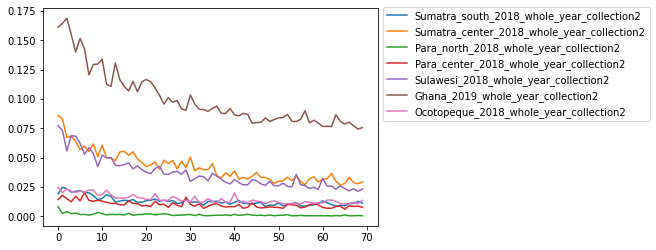

In [13]:
for dataset_idx in np.arange(len(datasets)):
    pl.plot(datasets_losses[dataset_idx], label=datasets_name[dataset_idx])
    
    print(datasets_losses[dataset_idx][-1])

pl.legend(bbox_to_anchor=(1, 1.03))

In [14]:
# remove last layer
model = Model(inputs=model.input, outputs=model.get_layer('last_input_layer').output)

# save model
model.save(MODEL_ROOT_PATH + 'multi_output_pretrained_with_reptile_v2.hdf5')

# Training with pretrained model

In [3]:
EPOCHS = 500
NB_TESTS = 4

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    Label.STICK_FOR_PEPPER,
    Label.PINE_TREES,
]

labels_names = [label.name for label in labels]
categories = pd.unique([category_from_label(label) for label in labels])

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [5]:
labels_coordinates = vietnam_labels_coordinates()

dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2018_whole_year_collection2/merged.tif'],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2018 = make_dataset_from_raster_files(**dataset_args)

dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2019_whole_year_collection2/merged.tif'],
    labels_coordinates_list = [labels_coordinates],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset_2019 = make_dataset_from_raster_files(**dataset_args)
np.random.shuffle(dataset_2019)

In [6]:
# Create train sets
labels_train = labels_from_dataset(dataset_2018, labels_names)
categories_train = categories_from_label_set(labels, labels_train)

X_train = images_from_dataset(dataset_2018, bands)
y_train = [labels_train, categories_train]
Y_train = [
    to_categorical(labels_train, num_classes=len(labels_names)), 
    to_categorical(categories_train, num_classes=len(categories)), 
]

# Create test sets
labels_test = labels_from_dataset(dataset_2019, labels_names)
categories_test = categories_from_label_set(labels, labels_test)

X_test = images_from_dataset(dataset_2019, bands)
y_test = [labels_test, categories_test]
Y_test = [
    to_categorical(labels_test, num_classes=len(labels_names)), 
    to_categorical(categories_test, num_classes=len(categories)), 
]

In [7]:
model_name = "january_to_april_2018_collection2_with_reptile"

# V1
# model = load_model(
#     MODEL_ROOT_PATH + 'multi_output_pretrained_with_reptile.hdf5',
#     custom_objects={
#         'categorical_focal_loss_fixed': categorical_focal_loss
#     }
# )

# V2
model = load_model(
    MODEL_ROOT_PATH + 'multi_output_pretrained_with_reptile_v2.hdf5',
    custom_objects={
        'categorical_focal_loss_fixed': categorical_focal_loss
    }
)


label_output = Dense(len(labels), activation='softmax', name="label")(model.output)
category_output = Dense(len(categories), activation='softmax', name="category")(model.output)

model = Model(inputs=model.input, outputs=[label_output, category_output])

model.compile(optimizer='adam', loss={
    'label': categorical_focal_loss([[.25] * len(labels)]),
    'category': categorical_focal_loss([[.25] * len(categories)])
}, metrics={
    'label': 'accuracy',
    'category': 'accuracy'
})

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9, 9, 7)]    0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 9, 9, 7)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 9, 7)      28          rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 9, 9, 32)     2048        batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
# create data generators
train_datagen = ImageMultiOutputSequence(
    X_train, Y_train, ['label', 'category'], batch_size=32, augmentations=AUGMENTATIONS
)

history, trained_model = train_model(
    model=model,
    train_datagen=train_datagen,
    validation_datagen=None,
    class_weights=None,
    epochs=EPOCHS,
    steps_per_epoch=len(labels_train) / 32,
    early_stopping=False,
    model_checkpoint_cb=False,
)

trained_model.save(os.path.join(MODEL_ROOT_PATH, model_name + '.hdf5'))

Epoch 1/500
431/431 [==============================] - 2s 4ms/step - loss: 0.5324 - label_loss: 0.4127 - category_loss: 0.1197 - label_accuracy: 0.3669 - category_accuracy: 0.7401
Epoch 2/500
431/431 [==============================] - 1s 3ms/step - loss: 0.3014 - label_loss: 0.2397 - category_loss: 0.0617 - label_accuracy: 0.5595 - category_accuracy: 0.8403
Epoch 3/500
431/431 [==============================] - 1s 3ms/step - loss: 0.2391 - label_loss: 0.1929 - category_loss: 0.0462 - label_accuracy: 0.6194 - category_accuracy: 0.8746
Epoch 4/500
431/431 [==============================] - 1s 3ms/step - loss: 0.2207 - label_loss: 0.1782 - category_loss: 0.0425 - label_accuracy: 0.6337 - category_accuracy: 0.8804
Epoch 5/500
431/431 [==============================] - 1s 3ms/step - loss: 0.2045 - label_loss: 0.1651 - category_loss: 0.0393 - label_accuracy: 0.6534 - category_accuracy: 0.8831
Epoch 6/500
431/431 [==============================] - 1s 3ms/step - loss: 0.1929 - label_loss: 0.15

431/431 [==============================] - 2s 4ms/step - loss: 0.1111 - label_loss: 0.0907 - category_loss: 0.0204 - label_accuracy: 0.7642 - category_accuracy: 0.9263
Epoch 47/500
431/431 [==============================] - 2s 4ms/step - loss: 0.1168 - label_loss: 0.0945 - category_loss: 0.0223 - label_accuracy: 0.7610 - category_accuracy: 0.9188
Epoch 48/500
431/431 [==============================] - 2s 4ms/step - loss: 0.1113 - label_loss: 0.0916 - category_loss: 0.0198 - label_accuracy: 0.7642 - category_accuracy: 0.9272
Epoch 49/500
431/431 [==============================] - 2s 4ms/step - loss: 0.1128 - label_loss: 0.0920 - category_loss: 0.0208 - label_accuracy: 0.7605 - category_accuracy: 0.9209
Epoch 50/500
431/431 [==============================] - 2s 4ms/step - loss: 0.1106 - label_loss: 0.0900 - category_loss: 0.0207 - label_accuracy: 0.7668 - category_accuracy: 0.9231
Epoch 51/500
431/431 [==============================] - 2s 4ms/step - loss: 0.1072 - label_loss: 0.0874 - ca

431/431 [==============================] - 2s 5ms/step - loss: 0.0951 - label_loss: 0.0780 - category_loss: 0.0170 - label_accuracy: 0.7891 - category_accuracy: 0.9331
Epoch 92/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0914 - label_loss: 0.0746 - category_loss: 0.0168 - label_accuracy: 0.7861 - category_accuracy: 0.9341
Epoch 93/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0975 - label_loss: 0.0794 - category_loss: 0.0181 - label_accuracy: 0.7843 - category_accuracy: 0.9297
Epoch 94/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0982 - label_loss: 0.0803 - category_loss: 0.0180 - label_accuracy: 0.7843 - category_accuracy: 0.9303
Epoch 95/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0923 - label_loss: 0.0753 - category_loss: 0.0170 - label_accuracy: 0.7896 - category_accuracy: 0.9306
Epoch 96/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0902 - label_loss: 0.0739 - ca

431/431 [==============================] - 2s 5ms/step - loss: 0.0908 - label_loss: 0.0741 - category_loss: 0.0167 - label_accuracy: 0.7970 - category_accuracy: 0.9366
Epoch 137/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0891 - label_loss: 0.0725 - category_loss: 0.0166 - label_accuracy: 0.7898 - category_accuracy: 0.9339
Epoch 138/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0822 - label_loss: 0.0673 - category_loss: 0.0149 - label_accuracy: 0.8074 - category_accuracy: 0.9398
Epoch 139/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0843 - label_loss: 0.0690 - category_loss: 0.0153 - label_accuracy: 0.8012 - category_accuracy: 0.9380
Epoch 140/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0867 - label_loss: 0.0710 - category_loss: 0.0157 - label_accuracy: 0.7963 - category_accuracy: 0.9372
Epoch 141/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0857 - label_loss: 0.0696

431/431 [==============================] - 2s 5ms/step - loss: 0.0849 - label_loss: 0.0686 - category_loss: 0.0162 - label_accuracy: 0.8082 - category_accuracy: 0.9368
Epoch 182/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0820 - label_loss: 0.0664 - category_loss: 0.0155 - label_accuracy: 0.8082 - category_accuracy: 0.9387
Epoch 183/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0776 - label_loss: 0.0636 - category_loss: 0.0140 - label_accuracy: 0.8156 - category_accuracy: 0.9425
Epoch 184/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0816 - label_loss: 0.0663 - category_loss: 0.0153 - label_accuracy: 0.8107 - category_accuracy: 0.9387
Epoch 185/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0832 - label_loss: 0.0674 - category_loss: 0.0158 - label_accuracy: 0.8070 - category_accuracy: 0.9384
Epoch 186/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0902 - label_loss: 0.0745

431/431 [==============================] - 2s 5ms/step - loss: 0.0769 - label_loss: 0.0629 - category_loss: 0.0140 - label_accuracy: 0.8172 - category_accuracy: 0.9449
Epoch 227/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0785 - label_loss: 0.0636 - category_loss: 0.0148 - label_accuracy: 0.8145 - category_accuracy: 0.9419
Epoch 228/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0767 - label_loss: 0.0623 - category_loss: 0.0144 - label_accuracy: 0.8124 - category_accuracy: 0.9417
Epoch 229/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0784 - label_loss: 0.0641 - category_loss: 0.0143 - label_accuracy: 0.8161 - category_accuracy: 0.9454
Epoch 230/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0778 - label_loss: 0.0635 - category_loss: 0.0143 - label_accuracy: 0.8113 - category_accuracy: 0.9383
Epoch 231/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0774 - label_loss: 0.0629

431/431 [==============================] - 2s 5ms/step - loss: 0.0781 - label_loss: 0.0626 - category_loss: 0.0155 - label_accuracy: 0.8153 - category_accuracy: 0.9422
Epoch 272/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0790 - label_loss: 0.0643 - category_loss: 0.0148 - label_accuracy: 0.8126 - category_accuracy: 0.9400
Epoch 273/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0726 - label_loss: 0.0592 - category_loss: 0.0134 - label_accuracy: 0.8192 - category_accuracy: 0.9450
Epoch 274/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0727 - label_loss: 0.0590 - category_loss: 0.0136 - label_accuracy: 0.8206 - category_accuracy: 0.9461
Epoch 275/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0758 - label_loss: 0.0616 - category_loss: 0.0142 - label_accuracy: 0.8170 - category_accuracy: 0.9424
Epoch 276/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0704 - label_loss: 0.0573

431/431 [==============================] - 2s 5ms/step - loss: 0.0704 - label_loss: 0.0571 - category_loss: 0.0133 - label_accuracy: 0.8272 - category_accuracy: 0.9474
Epoch 317/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0749 - label_loss: 0.0603 - category_loss: 0.0146 - label_accuracy: 0.8241 - category_accuracy: 0.9437
Epoch 318/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0731 - label_loss: 0.0594 - category_loss: 0.0137 - label_accuracy: 0.8232 - category_accuracy: 0.9429
Epoch 319/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0725 - label_loss: 0.0590 - category_loss: 0.0135 - label_accuracy: 0.8237 - category_accuracy: 0.9483
Epoch 320/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0700 - label_loss: 0.0573 - category_loss: 0.0127 - label_accuracy: 0.8250 - category_accuracy: 0.9461
Epoch 321/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0706 - label_loss: 0.0573

431/431 [==============================] - 2s 5ms/step - loss: 0.0689 - label_loss: 0.0560 - category_loss: 0.0129 - label_accuracy: 0.8280 - category_accuracy: 0.9481
Epoch 362/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0688 - label_loss: 0.0564 - category_loss: 0.0124 - label_accuracy: 0.8321 - category_accuracy: 0.9495
Epoch 363/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0821 - label_loss: 0.0666 - category_loss: 0.0155 - label_accuracy: 0.8106 - category_accuracy: 0.9421
Epoch 364/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0694 - label_loss: 0.0565 - category_loss: 0.0129 - label_accuracy: 0.8238 - category_accuracy: 0.9467
Epoch 365/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0728 - label_loss: 0.0588 - category_loss: 0.0140 - label_accuracy: 0.8248 - category_accuracy: 0.9457
Epoch 366/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0684 - label_loss: 0.0559

431/431 [==============================] - 2s 5ms/step - loss: 0.0707 - label_loss: 0.0569 - category_loss: 0.0139 - label_accuracy: 0.8252 - category_accuracy: 0.9461
Epoch 407/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0804 - label_loss: 0.0659 - category_loss: 0.0146 - label_accuracy: 0.8107 - category_accuracy: 0.9415
Epoch 408/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0697 - label_loss: 0.0566 - category_loss: 0.0131 - label_accuracy: 0.8251 - category_accuracy: 0.9487
Epoch 409/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0679 - label_loss: 0.0556 - category_loss: 0.0123 - label_accuracy: 0.8301 - category_accuracy: 0.9498
Epoch 410/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0725 - label_loss: 0.0586 - category_loss: 0.0139 - label_accuracy: 0.8269 - category_accuracy: 0.9469
Epoch 411/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0678 - label_loss: 0.0555

431/431 [==============================] - 2s 5ms/step - loss: 0.0701 - label_loss: 0.0567 - category_loss: 0.0134 - label_accuracy: 0.8309 - category_accuracy: 0.9487
Epoch 452/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0700 - label_loss: 0.0562 - category_loss: 0.0138 - label_accuracy: 0.8296 - category_accuracy: 0.9461
Epoch 453/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0670 - label_loss: 0.0544 - category_loss: 0.0125 - label_accuracy: 0.8318 - category_accuracy: 0.9499
Epoch 454/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0713 - label_loss: 0.0578 - category_loss: 0.0135 - label_accuracy: 0.8288 - category_accuracy: 0.9474
Epoch 455/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0696 - label_loss: 0.0561 - category_loss: 0.0135 - label_accuracy: 0.8338 - category_accuracy: 0.9479
Epoch 456/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0684 - label_loss: 0.0555

431/431 [==============================] - 2s 5ms/step - loss: 0.0683 - label_loss: 0.0558 - category_loss: 0.0125 - label_accuracy: 0.8324 - category_accuracy: 0.9492
Epoch 497/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0675 - label_loss: 0.0539 - category_loss: 0.0136 - label_accuracy: 0.8355 - category_accuracy: 0.9509
Epoch 498/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0652 - label_loss: 0.0536 - category_loss: 0.0116 - label_accuracy: 0.8373 - category_accuracy: 0.9510
Epoch 499/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0706 - label_loss: 0.0571 - category_loss: 0.0134 - label_accuracy: 0.8319 - category_accuracy: 0.9486
Epoch 500/500
431/431 [==============================] - 2s 5ms/step - loss: 0.0757 - label_loss: 0.0612 - category_loss: 0.0145 - label_accuracy: 0.8198 - category_accuracy: 0.9388


In [9]:
conf_matrices, accuracy, loss = evaluate_multi_output_model(trained_model, X_test, Y_test, y_test)

In [10]:
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  0.12303142994642258
accuracy:  0.10071244835853577


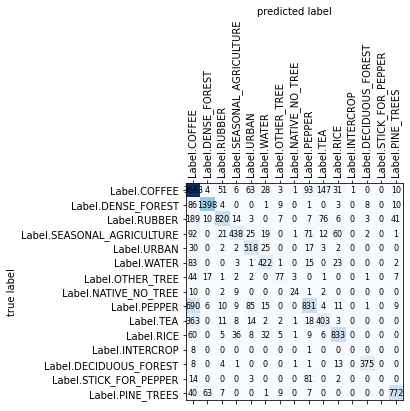

In [11]:
plot_confusion_matrix(conf_matrices[0], labels)

In [12]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[0])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.68085502 0.93324433 0.87420043 0.82954545 0.71745152 0.77431193
 0.68141593 0.75       0.72072853 0.61620795 0.84397163 0.
 0.96153846        nan 0.90610329]
Mean precision:  nan

Recalls:  [0.89319678 0.91973684 0.69727891 0.5902965  0.86477462 0.76727273
 0.49677419 0.5        0.497307   0.48848485 0.83718593 0.
 0.93052109 0.         0.85873192]
Mean recall:  0.6227707581463287

F-Score:  [0.7727033  0.92644135 0.77578051 0.68976378 0.78425435 0.77077626
 0.57462687 0.6        0.58852691 0.54496281 0.84056509        nan
 0.94577554        nan 0.88178184]
Mean f-score:  nan


/home/simon/Documents/HEIG/TB/scripts/notebooks/../src/statisticsUtils.py:104: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)
/home/simon/Documents/HEIG/TB/scripts/notebooks/../src/statisticsUtils.py:106: RuntimeWarning: invalid value encountered in true_divide
  fscore = 2 * recall * precision / (recall + precision)


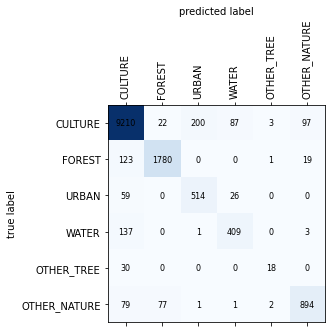

In [13]:
plot_confusion_matrix(conf_matrices[1], [category.name for category in categories])

In [14]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrices[1])

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.95559245 0.9473124  0.71787709 0.78202677 0.75       0.88252715]
Mean precision:  0.8392226429134881

Recalls:  [0.95747999 0.92563703 0.85809683 0.74363636 0.375      0.84819734]
Mean recall:  0.7846745913570548

F-Score:  [0.95653529 0.93634929 0.78174905 0.76234856 0.5        0.86502177]
Mean f-score:  0.800333991880222
